# Init

In [3]:
!pip install --upgrade gensim
!pip install pyLDAvis
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.3 MB/s eta 0:00:0000:0100:01


In [26]:
#geral
import pickle
import pandas as pd
import pyLDAvis
import pyLDAvis.lda_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

In [6]:
with open('df_proc.p', 'rb') as file:
    df = pickle.load(file)
df.head()

,text
0,programa treinamento jornalismo agroindústria ...
1,ofício enviado juiz sergio moro feira presiden...
2,ex governador rio sérgio cabral transferido co...
3,aplausos vaias juiz federal sergio moro respon...
4,ex executivo empreiteira odebrecht afirmou aco...


# LDA

## Calcular numero de topicos

In [7]:
tokenized_docs = [doc.lower().split() for doc in df['text']]

In [8]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(text) for text in tokenized_docs]

In [23]:
def compute_coherence_values(corpus, dictionary, texts, range_lda): # meu
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range_lda):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
limit=1; start=100; step=-1;
range_lda = range(start, limit, step)
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=id2word, texts=tokenized_docs, range_lda=range_lda)

## Visualizar coerencia

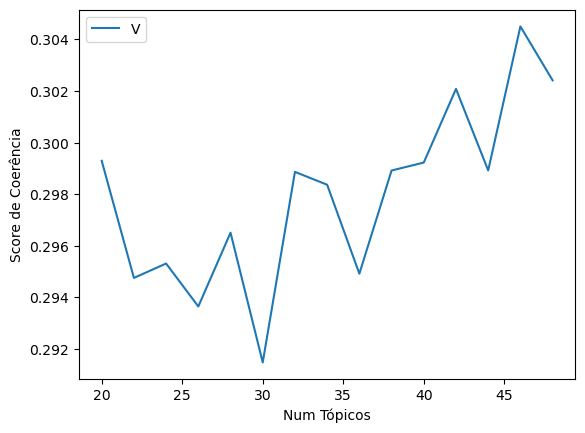

In [22]:
x = range_lda
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

## Salvar melhor modelo

In [33]:
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]
optimal_num_topics = optimal_model.num_topics

print(f"Melhor número de tópicos: {optimal_num_topics}")

Melhor número de tópicos: 2


In [34]:
def get_document_topic(lda_model, corpus):
    document_topics = []
    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow, minimum_probability=0.0)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        document_topics.append(dominant_topic)
    return document_topics

In [35]:
document_topics = get_document_topic(optimal_model, corpus)

In [36]:
df = pd.DataFrame({'doc': df['text'], 'topic': document_topics})
df.head()

,doc,topic
0,programa treinamento jornalismo agroindústria ...,1
1,ofício enviado juiz sergio moro feira presiden...,0
2,ex governador rio sérgio cabral transferido co...,0
3,aplausos vaias juiz federal sergio moro respon...,0
4,ex executivo empreiteira odebrecht afirmou aco...,0


In [37]:
def get_topic_words(lda_model, num_words=5):
    topic_words = {}
    for i, topic in enumerate(lda_model.show_topics(formatted=False, num_words=num_words)):
        topic_words[i] = [word for word, _ in topic[1]]
    return topic_words

# Obter as palavras representativas para cada tópico
topic_words = get_topic_words(optimal_model, num_words=5)

# Exibir os tópicos e suas palavras mais importantes
for topic, words in topic_words.items():
    print(f"Tópico {topic}: {' '.join(words)}")

Tópico 0: presidente disse governo brasil paulo
Tópico 1: ano anos – paulo dia


# LDA visualizer

In [16]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare

<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [17]:
pyLDAvis.lda_model.prepare(optimal_model, tfidf_matrix, tfidf_vectorizer, sort_topics=False, mds='tsne')

AttributeError: 'Series' object has no attribute 'getA1'